In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from statistics import stdev, pstdev
from scipy.stats import t

## Ceny miedzi na przestrzeni 5 lat (bierzemy ceny otwarcia Open)

In [2]:
copper = pd.read_csv('copper.csv', sep = ',', encoding = 'latin-1')
copper

,Date,Close/Last,Volume,Open,High,Low
0,03/28/2023,4.0855,75067,4.0970,4.1130,4.0590
1,03/27/2023,4.0785,65558,4.0750,4.1020,4.0235
2,03/24/2023,4.0750,82229,4.1015,4.1485,4.0505
3,03/23/2023,4.1235,77824,4.0430,4.1265,4.0225
4,03/22/2023,4.0445,77119,4.0015,4.1075,3.9715
...,...,...,...,...,...,...
1254,04/05/2018,3.0745,107499,3.0285,3.0880,3.0135
1255,04/04/2018,3.0105,137745,3.0670,3.0695,2.9700
1256,04/03/2018,3.0635,109250,3.0445,3.0695,3.0385
1257,04/02/2018,3.0500,68976,3.0480,3.0725,3.0370


## Wykres cen miedzi - jeszcze upiększyć

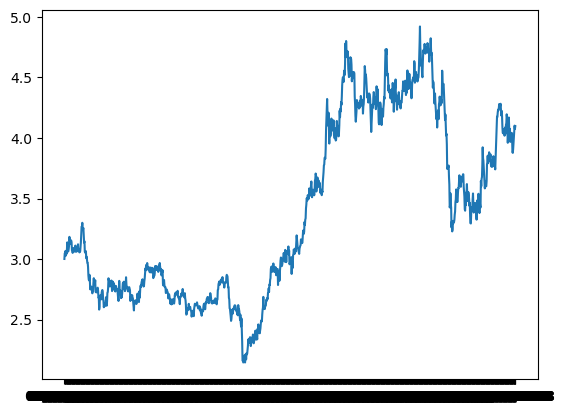

In [3]:
plt.plot(copper['Date'].values[::-1], copper['Open'].values[::-1])
plt.show()

## Histogram logarytmicznych przyrostów

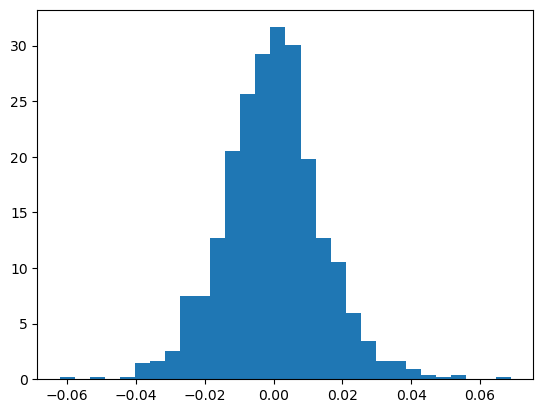

In [4]:
s = np.array(copper['Open'].values[1:])
s2 = np.array(copper['Open'].values[:-1])
r = np.log(s/s2)
plt.hist(r, bins = 30, density = True)
plt.show()

## Miary zmienności ryzyka

#### Podejście parametryczne

In [14]:
def norm_kde(x, mi, sigma): # (n - 1) - stopnie swobody dla t-studenta
    x = np.array(sorted(x))
    y = 1/(math.sqrt(2*math.pi)*sigma)*np.exp(-(x - mi)**2/(2*sigma**2))
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1) 
    plt.plot(x, y, color = 'blue', label = 'normal pdf')
    plt.hist(x, bins = 50, density = True, color = 'red', ec = 'black')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.legend()
    plt.show()

In [29]:
mu = np.mean(r)
s = stdev(r)
s2 = math.sqrt(np.sum((r - np.mean(r))**2)/(len(r) - 1))
print('Średnia: ' + str(mu))
print('Odchylenie standardowe: ' + str(s))

Średnia: -0.00024746377750914307
Odchylenie standardowe: 0.014277995279475233


In [30]:
s2

0.014277995279475233

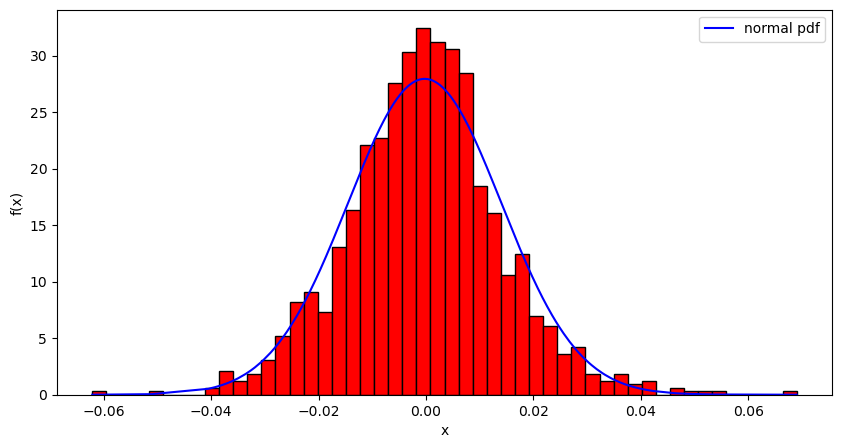

In [26]:
norm_kde(r, mu, s)

#### Podejście nieparametryczne

In [31]:
def cdf(x, mi, sigma):
    x = np.array(sorted(x))
    y = 1/2*(1 + erf((x - mi)/sigma*math.sqrt(2)))
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(x, y, color = 'black', label = 'CDF', linestyle = 'dashdot')
    sns.ecdfplot(data = rainfall3, color = 'red', label = 'ECDF')
    plt.xlabel('e')
    plt.ylabel('F(e)')
    plt.legend()
    plt.show()